Test methods for accessing CESM1 and CMIP6 output via Pangeo methodologies
February 2024


In [71]:
# Packages needed generally
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs

# Packages needed for CMIP6
import zarr
import gcsfs

Example 1: CESM1 Large Ensemble

Here I will demonstrate how to extract information from the CESM1 Large Ensemble hosted on Amazon Web Services, following similar steps as

https://github.com/dianaxnav/cesm-lens-aws-dn/tree/main

This has been modified to also include functionality to load a zarr-format grid file containing the latitude and longitude information for CESM1, which for some reason are not included in the data files.

Things to note:

    The grid file used here is only for OCEAN variables; the atmosphere and land have different lat and lon information.
    For most ocean variables, latitude and longitude are called "TLAT" and "TLONG".



In [2]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)
col

# Location of file containing grid (lat/lon) information for CESM1 LENS
grid_url="s3://ncar-cesm-lens/ocn/static/grid.zarr"


The name of the ocean temperature variable is "TEMP"; a full list of CESM-specific variable names can be found here:

https://www.cesm.ucar.edu/community-projects/lens2/output-variables


In [3]:
# Search for the TEMP variable, display the first few entries in the resulting data frame
col.search(variable="TEMP").df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,CTRL,monthly,60.0,global_ocean,degC,0400-01-16 12:00:00,2200-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-CTRL-TE...
2,TEMP,potential temperature,ocn,HIST,monthly,60.0,global_ocean,degC,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-TE...
3,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [4]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
# ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members)
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="TEMP",
    experiment=["20C", "RCP85"],  
)

col_ocntemp.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [5]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets = col_ocntemp.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


/Users/p_park/.conda/envs/channelislanders/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/Users/p_park/.conda/envs/channelislanders/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)



Dataset dictionary keys:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])


In [6]:
# Get file containing lat/lon grid information: s3://ncar-cesm-lens/ocn/static/grid.zarr
fs = s3fs.S3FileSystem(anon=True)
grid = xr.open_zarr(fs.get_mapper(grid_url), consolidated=True)

In [7]:
# Define Xarray datasets corresponding to the three experiments
ds_20C = dsets["ocn.20C.monthly"]
ds_RCP85 = dsets["ocn.RCP85.monthly"]

In [14]:
ds_20C

<xarray.Dataset>
Dimensions:     (member_id: 40, time: 1032, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 6, 60, 384, 320), meta=np.ndarray>
Attributes: (12/24)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    nsteps_total:                      750
    ...                                ...
    intake_esm_attrs:units:            degC
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/ocn/monthly/cesmLE...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

In [9]:
#for 1920 to 2000
ds_20C_mean=ds_20C.mean(dim="member_id")

In [40]:
ds_20C_mean

<xarray.Dataset>
Dimensions:     (time: 1032, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(6, 60, 384, 320), meta=np.ndarray>

In [10]:
test = ds_20C_mean.TEMP.sel(time=slice("1950", "2000"))

In [68]:
test

<xarray.DataArray 'TEMP' (time: 612, z_t: 60, nlat: 384, nlon: 320)>
dask.array<getitem, shape=(612, 60, 384, 320), dtype=float32, chunksize=(6, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1950-01-16 12:00:00 ... 2000-12-16 12:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon

In [76]:
# define the extent of the map
lonW = -140
lonE = -40
latS = 15
latN = 65
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
res = '110m'

AttributeError: 'Axes' object has no attribute 'set_extent'

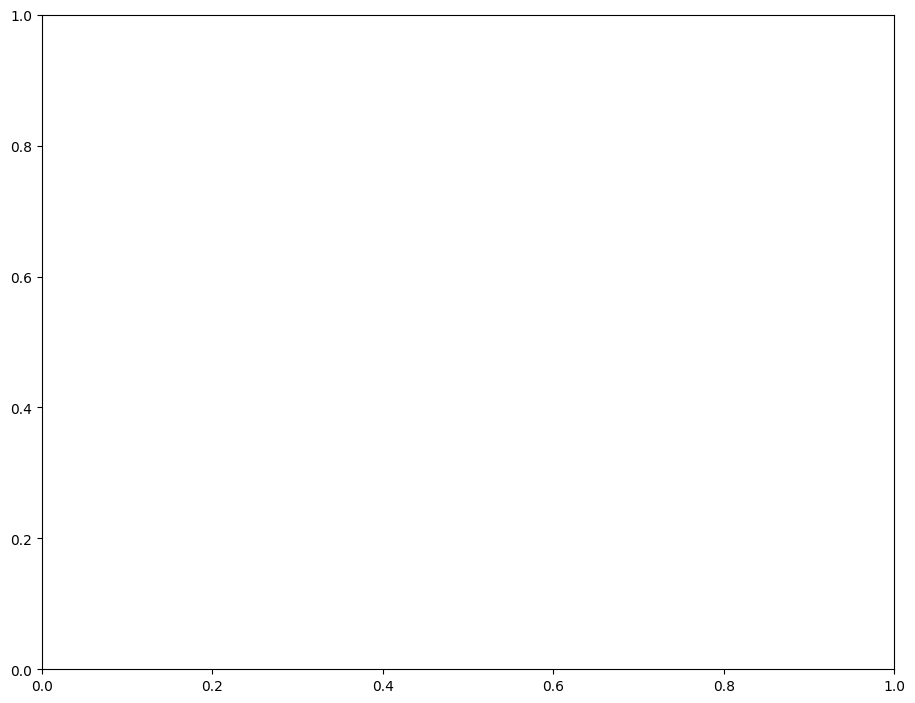

In [77]:
# what does sea surface temperature around the US look like? (i.e. where would you like to go swimming..)
fig = plt.figure(figsize=(11, 8.5))
ax = plt.subplot()
ax.set_title('')
ax.set_extent([lonW, lonE, latS, latN], crs = 'EPSG:3857');
tdat = ax.pcolormesh(test.isel(z_t=0, time=10), cmap='RdYlBu_r')
plt.colorbar(tdat, ax=ax, shrink=0.5, pad=0.1)
#plt.savefig('basics_plot_4.png', bbox_inches='tight')# uncomment this to save your figure

# subsetting to just channel islands

<Axes: >

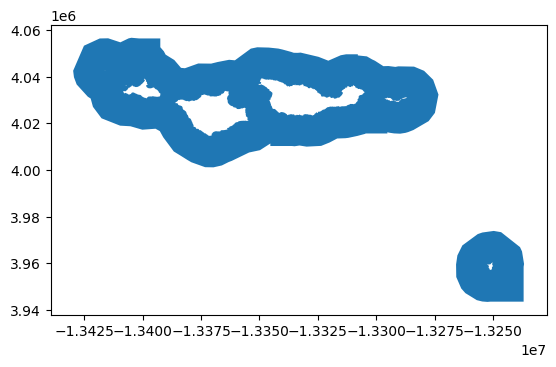

In [41]:
import geopandas as gpd

# path to channel island shapefile
cinms = 'cinms_py'

# Read the shapefile
pts = gpd.read_file(cinms)

# Define the target projected CRS (e.g., WGS 84 / Pseudo-Mercator)
target_crs = 'EPSG:3857'  # WGS 84 / Pseudo-Mercator EPSG code

# Reproject the geometries to the target CRS
pts = pts.to_crs(target_crs)

pts.plot()

In [48]:
#view contents of channel island geopanda dataframe
pts

,SANCTUARY,AREA_NAME,POLY_ID,DATUM,geometry
0,CINMS,Santa Barbara Section,2,NAD83,"POLYGON ((-13251104.830 3943612.515, -13252376..."
1,CINMS,Northern Section,1,NAD83,"POLYGON ((-13404871.556 4056640.473, -13401564..."


In [ ]:
#find coordinates of channel islands
ch_coords = pts.get_coordinates()
ch_coords

In [ ]:
# Add multiple columns using dictionary assignment
#adding back into pts dataframe
# creating new columns for lat and long
#new_data = {'x': ch_coords["x"], 'y': ch_coords["y"] }
#pts = pts.assign(**new_data)

#just add one into pts dataframe
#pts['x'] = ch_coords["x"]
#pts

In [66]:
import numpy as np
# Get the centroid of each geometry
centroids = pts.geometry.centroid
#centroids
#here i want to extract shape file points and match them to the xarray dataset file I have in CMIP6
lons = np.array(centroids.geometry.x.to_list())
lats = np.array(centroids.geometry.y.to_list())
lons

array([-13250646.84818736, -13354051.37369394])